# Training

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_LAUNCH_BLOCKING=1
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import logging

import matplotlib.pyplot as plt
import numpy as np

import sys; sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Shapes")
data_dir = root_dir / "Data"
model_dir = root_dir / "Models"
model_dir.mkdir(exist_ok=True)

# Import the configuration associated with this dataset and network.
config = maskflow.config.load_config(root_dir / "config.yaml")

env: CUDA_VISIBLE_DEVICES=0
env: CUDA_LAUNCH_BLOCKING=1


## Check Dataset

2018-11-03 15:42:24,358:WARNING:maskrcnn_benchmark.data.build: When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


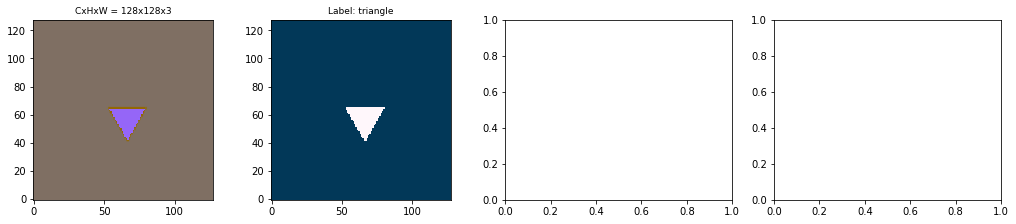

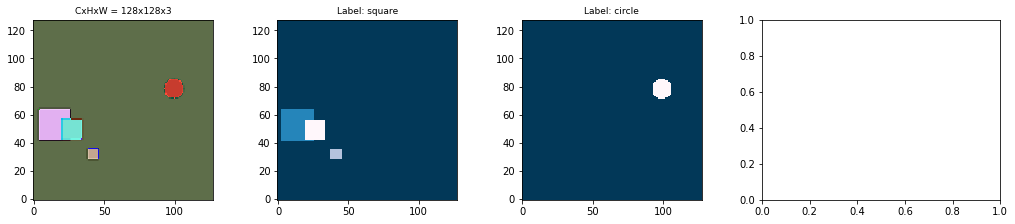

In [2]:
config['SOLVER']['IMS_PER_BATCH'] = 2
config['TEST']['IMS_PER_BATCH'] = 2

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=True)
some_data = [iter(data_loader).next() for _ in range(1)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

for batch_image, batch_target, batch_idx in some_data:
    maskflow.viz.batch_display_top_masks(batch_image, batch_target, batch_idx, categories,
                                         basesize=14, limit=3, cmap="PuBu_r")

## Training

In [3]:
# Use the last model in the model dir
# If False, create a new model from scratch.
# If `model_to_use` is set, we use this one instead.
use_last_model = True
model_to_use = None

# Configure the training
config['DATA_DIR'] = str(data_dir)

config['MODEL']['DEVICE'] = "cuda"

config['DATALOADER']['NUM_WORKERS'] = 16
config['SOLVER']['IMS_PER_BATCH'] = 8

config['SOLVER']['MAX_ITER'] = 50
config['SOLVER']['BASE_LR'] = 0.0002
config['SOLVER']['STEPS'] = [40, 80]
config['SOLVER']['CHECKPOINT_PERIOD'] = 50

In [4]:
# Setup training
training_args, current_model_path = maskflow.training.build_model(config,
                                                                  model_dir,
                                                                  use_last_model=use_last_model,
                                                                  model_to_use=model_to_use)

# Train
from maskrcnn_benchmark.engine.trainer import do_train

logging.info(f"Start training at iteration {training_args['arguments']['iteration']}")
do_train(**training_args)

2018-11-03 15:42:29,808:INFO:root: Training model directory set: /home/hadim/.data/Neural_Network/Maskflow/Shapes/Models/2018.11.03-14:05:20
2018-11-03 15:42:29,809:INFO:root: Building the model...
2018-11-03 15:42:32,365:INFO:maskrcnn_benchmark.utils.checkpoint: Loading checkpoint from /home/hadim/.data/Neural_Network/Maskflow/Shapes/Models/2018.11.03-14:05:20/model_0000300.pth
2018-11-03 15:42:32,610:INFO:maskrcnn_benchmark.utils.checkpoint: Loading optimizer from /home/hadim/.data/Neural_Network/Maskflow/Shapes/Models/2018.11.03-14:05:20/model_0000300.pth
2018-11-03 15:42:32,737:INFO:maskrcnn_benchmark.utils.checkpoint: Loading scheduler from /home/hadim/.data/Neural_Network/Maskflow/Shapes/Models/2018.11.03-14:05:20/model_0000300.pth
2018-11-03 15:42:32,738:INFO:root: Create the data loader.
2018-11-03 15:42:32,738:WARNING:maskrcnn_benchmark.data.build: When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory.

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2018-11-03 15:42:34,204:INFO:maskrcnn_benchmark.trainer: eta: -1 day, 23:54:01  iter: 300  loss: 2.1174 (2.1174)  loss_classifier: 0.2710 (0.2710)  loss_box_reg: 0.0284 (0.0284)  loss_mask: 1.0617 (1.0617)  loss_objectness: 0.4112 (0.4112)  loss_rpn_box_reg: 0.3451 (0.3451)  time: 1.4361 (1.4361)  data: 0.7308 (0.7308)  lr: 0.000001  max mem: 1008
2018-11-03 15:42:34,206:INFO:maskrcnn_benchmark.utils.checkpoint: Saving checkpoint to /home/hadim/.data/Neural_Network/Maskflow/Shapes/Models/2018.11.03-14:05:20/model_0000300.pth
2018-11-03 15:42:47,194:INFO:maskrcnn_benchmark.trainer: eta: -1 day, 23:56:55  iter: 320  loss: 1.8782 (1.9117)  loss_classifier: 0.1795 (0.1865)  loss_box_reg: 0.0192 (0.0200)  loss_mask: 1.0488 (1.0463)  loss_objectness: 0.3633 (0.3651)  loss_rpn_box_reg: 0.2984 (0.2938)  time: 0.6167 (0.6870)  data: 0.0008 (0.0812)  lr: 0.000002  max mem: 1209
2018-11-03 15:42:59,181:INFO:maskrcnn_benchmark.trainer: eta: -1 day, 23:56:54  iter: 340  loss: 1.8795 (1.8889)  loss_